#Sentiment Analysis Twitter with [snscrape] and [vader]

Referensi :

*   https://www.youtube.com/watch?v=jtIMnmbnOFo
*   https://towardsdatascience.com/step-by-step-twitter-sentiment-analysis-in-python-d6f650ade58d


## Install Modules and Import Library

In [ ]:
!pip install textblob
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# data scraping
import snscrape.modules.twitter as sntwitter

# sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# chart
import matplotlib.pyplot as plt

# data cleaning
import re
import string

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Data Scraping

Library = `snscrape`

data scraping twitter menurut search keyword \
Time Range = 1 Januari 2022 - 20 April 2022 \
Keyword =
*   ui ux
*   android develop

Hasil data scraping akan disimpan di runtime ini

Karena proses run lama, gapapa kalo section ini gausah di run lagi. Langsung import dataset hasil scraping di section bawahnya


# **SQL**

In [ ]:
# Scraping sql
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_sql.csv')

## Sentiment Keyword = SQL

### Import Dataset

In [ ]:
#import dataset android Dev
url='https://drive.google.com/file/d/1MJRCW5el4eEqSuHX6O8SVMoDDdzyb06T/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "sql lang:id since:2022-01-01"

sql = pd.read_csv(file_name)
sql.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 21:52:40+00:00,dwiyan_sql,@AREAJULID Bentaran doang pasti kasusnya. Nant...
1,1,2022-04-19 19:52:33+00:00,doublecl1ck,@phyton_sql 🫠 nasaan?!
2,2,2022-04-19 17:53:31+00:00,dwiyan_sql,Mendidik untuk kebaikan dirinya sendiri.\nBuka...
3,3,2022-04-19 17:28:39+00:00,dwiyan_sql,*ramalansesat\nTanda-tanda bakal ada gempa di ...
4,4,2022-04-19 16:12:25+00:00,sqL_handLe,#sqlserver\nMemory-optimized tempdb metadata (...


In [ ]:
sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2235 non-null   int64 
 1   Date        2235 non-null   object
 2   User        2235 non-null   object
 3   Tweet       2235 non-null   object
dtypes: int64(1), object(3)
memory usage: 70.0+ KB


### Data Preprocessing

*   Menghapus Row yang Null
*   menghapus Row yang sama (duplicate row)
*   Memfilter Retweet, tag, dan link
*   Mengubah Tweet ke dalam bentuk lowercase
*   Menghapus Kolom yang tidak digunakan



In [ ]:
tw_list = sql

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 21:52:40+00:00,dwiyan_sql,bentaran doang pasti kasusnya. nanti juga ila...,@AREAJULID Bentaran doang pasti kasusnya. Nant...
1,1,2022-04-19 19:52:33+00:00,doublecl1ck,🫠 nasaan?!,@phyton_sql 🫠 nasaan?!
2,2,2022-04-19 17:53:31+00:00,dwiyan_sql,mendidik untuk kebaikan dirinya sendiri.\nbuka...,Mendidik untuk kebaikan dirinya sendiri.\nBuka...
3,3,2022-04-19 17:28:39+00:00,dwiyan_sql,*ramalansesat\ntanda-tanda bakal ada gempa di ...,*ramalansesat\nTanda-tanda bakal ada gempa di ...
4,4,2022-04-19 16:12:25+00:00,sqL_handLe,#sqlserver\nmemory-optimized tempdb metadata (...,#sqlserver\nMemory-optimized tempdb metadata (...


Note :

[Tweet] = Hasil Filter \
[text] = Raw Tweet

In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

### Sentiment Analysis

Library = vader

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0

# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 21:52:40+00:00,dwiyan_sql,bentaran doang pasti kasusnya. nanti juga ila...,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
1,2022-04-19 19:52:33+00:00,doublecl1ck,🫠 nasaan?!,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
2,2022-04-19 17:53:31+00:00,dwiyan_sql,mendidik untuk kebaikan dirinya sendiri.\nbuka...,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
3,2022-04-19 17:28:39+00:00,dwiyan_sql,*ramalansesat\ntanda-tanda bakal ada gempa di ...,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
4,2022-04-19 16:12:25+00:00,sqL_handLe,#sqlserver\nmemory-optimized tempdb metadata (...,0.0,0.00,negative,0.179,0.821,0.0,-0.3400
5,2022-04-19 15:05:45+00:00,probablyurs,woi chi km hoki sql,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
6,2022-04-19 14:25:59+00:00,BinibiningIkay,sql nyo nangangain ng tanga jusq po,0.0,0.00,negative,0.375,0.625,0.0,-0.5574
7,2022-04-19 12:12:33+00:00,MuthoniMaryanne,tulisoma sql 2 weeks then week 3 tukakimbishw...,0.0,0.00,neutral,0.000,1.000,0.0,0.0000
8,2022-04-19 11:54:49+00:00,Jokitugsfess,joktug! need joki seputar database sql dl nant...,0.0,0.00,negative,0.193,0.807,0.0,-0.3382
9,2022-04-19 11:52:45+00:00,ManajemenData,2022-04-19: data dalam database adalah 7812 ba...,0.0,0.75,neutral,0.000,1.000,0.0,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
14,2022-04-19 03:15:39+00:00,abde_sql,wayah 0 clean sheet walakin hanya li jay hsn...,0.366667,0.700,positive,0.0,0.787,0.213,0.4019
16,2022-04-18 16:36:09+00:00,anggun1626,"day 2\n\nhari ini aku belajar tentang sql, mel...",-0.125000,0.375,positive,0.0,0.871,0.129,0.5719
31,2022-04-18 07:18:08+00:00,satang_haeyo,gue pengen cepet pinter python sama sql biar g...,0.000000,0.000,positive,0.0,0.833,0.167,0.4588


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
4,2022-04-19 16:12:25+00:00,sqL_handLe,#sqlserver\nmemory-optimized tempdb metadata (...,0.0,0.0,negative,0.179,0.821,0.0,-0.3400
6,2022-04-19 14:25:59+00:00,BinibiningIkay,sql nyo nangangain ng tanga jusq po,0.0,0.0,negative,0.375,0.625,0.0,-0.5574
8,2022-04-19 11:54:49+00:00,Jokitugsfess,joktug! need joki seputar database sql dl nant...,0.0,0.0,negative,0.193,0.807,0.0,-0.3382


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 21:52:40+00:00,dwiyan_sql,bentaran doang pasti kasusnya. nanti juga ila...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-19 19:52:33+00:00,doublecl1ck,🫠 nasaan?!,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-19 17:53:31+00:00,dwiyan_sql,mendidik untuk kebaikan dirinya sendiri.\nbuka...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,135,6.04
positive,344,15.39
neutral,1756,78.57


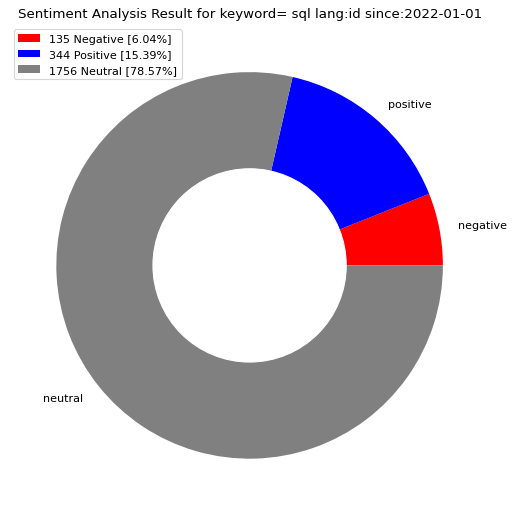

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kursus SQL**

In [ ]:
query = "kursus sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kursussql.csv')

In [ ]:
url='https://drive.google.com/file/d/1laiFmI93JlBT2ItpAmMSOmVBNLDBTGgb/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kursus sql lang:id since:2022-01-01"

kursusSQL = pd.read_csv(file_name)
kursusSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-16 07:13:20+00:00,ittkia_,@worksfess Kak aku mau coba boleh? Mau dm juga...
1,1,2022-04-16 05:03:57+00:00,ntbadanymore,@worksfess Aku engineer di subcon yg menjalank...
2,2,2022-04-06 03:18:30+00:00,FSyah1111,"@worksfess Contoh, ambil kursus terpisah ttg E..."
3,3,2022-04-04 09:15:47+00:00,WebHozz,Kursus SQL Server bersama mba Tasya dan mas Za...
4,4,2022-03-25 12:17:50+00:00,WebHozz,Kursus SQL Server dan Web Programming bersama ...


In [ ]:
kursusSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8 non-null      int64 
 1   Date        8 non-null      object
 2   User        8 non-null      object
 3   Tweet       8 non-null      object
dtypes: int64(1), object(3)
memory usage: 384.0+ bytes


In [ ]:
tw_list = kursusSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,@worksfess Kak aku mau coba boleh? Mau dm juga...
1,1,2022-04-16 05:03:57+00:00,ntbadanymore,aku engineer di subcon yg menjalankan project...,@worksfess Aku engineer di subcon yg menjalank...
2,2,2022-04-06 03:18:30+00:00,FSyah1111,"contoh, ambil kursus terpisah ttg excel/sprea...","@worksfess Contoh, ambil kursus terpisah ttg E..."
3,3,2022-04-04 09:15:47+00:00,WebHozz,kursus sql server bersama mba tasya dan mas za...,Kursus SQL Server bersama mba Tasya dan mas Za...
4,4,2022-03-25 12:17:50+00:00,WebHozz,kursus sql server dan web programming bersama ...,Kursus SQL Server dan Web Programming bersama ...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,0.000,0.000000,positive,0.0,0.916,0.084,0.3182
1,2022-04-16 05:03:57+00:00,ntbadanymore,aku engineer di subcon yg menjalankan project...,0.000,0.000000,neutral,0.0,1.000,0.000,0.0000
2,2022-04-06 03:18:30+00:00,FSyah1111,"contoh, ambil kursus terpisah ttg excel/sprea...",-0.125,0.375000,neutral,0.0,1.000,0.000,0.0000
3,2022-04-04 09:15:47+00:00,WebHozz,kursus sql server bersama mba tasya dan mas za...,0.000,0.000000,neutral,0.0,1.000,0.000,0.0000
4,2022-03-25 12:17:50+00:00,WebHozz,kursus sql server dan web programming bersama ...,0.300,0.500000,neutral,0.0,1.000,0.000,0.0000
5,2022-02-23 11:28:27+00:00,iamnotprfctprsn,saya telah mendapatkan sertifikat dari progate...,0.000,0.000000,neutral,0.0,1.000,0.000,0.0000
6,2022-01-19 09:16:42+00:00,effulgencz,"ngga cuma excel nder, kalo udah masuk data an...",0.000,0.000000,positive,0.0,0.846,0.154,0.4939
7,2022-01-06 17:37:49+00:00,FSyah1111,karena pengen jd analis skrg lagi belajar\n- ...,0.200,0.308333,positive,0.0,0.828,0.172,0.7845


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-16 07:13:20+00:00,ittkia_,kak aku mau coba boleh? mau dm juga ya kak pl...,0.0,0.000000,positive,0.0,0.916,0.084,0.3182
6,2022-01-19 09:16:42+00:00,effulgencz,"ngga cuma excel nder, kalo udah masuk data an...",0.0,0.000000,positive,0.0,0.846,0.154,0.4939
7,2022-01-06 17:37:49+00:00,FSyah1111,karena pengen jd analis skrg lagi belajar\n- ...,0.2,0.308333,positive,0.0,0.828,0.172,0.7845


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-16 05:03:57+00:00,ntbadanymore,aku engineer di subcon yg menjalankan project...,0.000,0.000,neutral,0.0,1.0,0.0,0.0
2,2022-04-06 03:18:30+00:00,FSyah1111,"contoh, ambil kursus terpisah ttg excel/sprea...",-0.125,0.375,neutral,0.0,1.0,0.0,0.0
3,2022-04-04 09:15:47+00:00,WebHozz,kursus sql server bersama mba tasya dan mas za...,0.000,0.000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,3,37.5
neutral,5,62.5


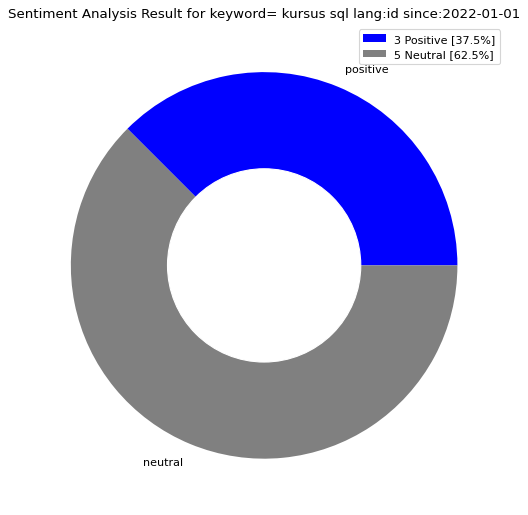

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
#negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
#neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [#str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **SQL Course**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "sql course lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_sqlcourse.csv')

In [ ]:
url='https://drive.google.com/file/d/1LXsye9KVPh1c84lrvyINzDCvo5Zq6lyd/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "sql course lang:id since:2022-01-01"

SQLcourse = pd.read_csv(file_name)
SQLcourse.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-17 01:01:21+00:00,Marianing8,"@worksfess Butuh course tableau, pyhton ama sq..."
1,1,2022-04-16 23:20:32+00:00,dyo_uchi,"@ozeanregen Anjir beneran, aku pas akhir tahun..."
2,2,2022-04-16 15:15:39+00:00,mufqam,@saltykittenz @pacarchanyeolll @worksfess bole...
3,3,2022-04-16 06:25:08+00:00,wkyarjn,@worksfess boleh tau ambil course sql itu dmn?
4,4,2022-04-16 06:20:58+00:00,0xayang,melihat ini ku jadi mau ambil course sql phyto...


In [ ]:
SQLcourse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35 non-null     int64 
 1   Date        35 non-null     object
 2   User        35 non-null     object
 3   Tweet       35 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.2+ KB


In [ ]:
tw_list = SQLcourse

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-17 01:01:21+00:00,Marianing8,"butuh course tableau, pyhton ama sql yg rekom...","@worksfess Butuh course tableau, pyhton ama sq..."
1,1,2022-04-16 23:20:32+00:00,dyo_uchi,"anjir beneran, aku pas akhir tahun juga beli ...","@ozeanregen Anjir beneran, aku pas akhir tahun..."
2,2,2022-04-16 15:15:39+00:00,mufqam,boleh rekomen yt atau course gratis sql ga ...,@saltykittenz @pacarchanyeolll @worksfess bole...
3,3,2022-04-16 06:25:08+00:00,wkyarjn,boleh tau ambil course sql itu dmn?,@worksfess boleh tau ambil course sql itu dmn?
4,4,2022-04-16 06:20:58+00:00,0xayang,melihat ini ku jadi mau ambil course sql phyto...,melihat ini ku jadi mau ambil course sql phyto...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 01:01:21+00:00,Marianing8,"butuh course tableau, pyhton ama sql yg rekom...",0.00,0.0000,neutral,0.0,1.000,0.000,0.0000
1,2022-04-16 23:20:32+00:00,dyo_uchi,"anjir beneran, aku pas akhir tahun juga beli ...",0.00,0.0000,neutral,0.0,1.000,0.000,0.0000
2,2022-04-16 15:15:39+00:00,mufqam,boleh rekomen yt atau course gratis sql ga ...,0.00,0.0000,positive,0.0,0.870,0.130,0.0516
3,2022-04-16 06:25:08+00:00,wkyarjn,boleh tau ambil course sql itu dmn?,0.00,0.0000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-16 06:20:58+00:00,0xayang,melihat ini ku jadi mau ambil course sql phyto...,0.00,0.0000,neutral,0.0,1.000,0.000,0.0000
5,2022-04-13 09:25:00+00:00,worksfess,work! klo beli course datacamp buat belajar sq...,0.30,0.1000,positive,0.0,0.818,0.182,0.5349
6,2022-04-12 10:03:40+00:00,karirfess,kr! klo beli course datacamp buat belajar sql ...,0.30,0.1000,positive,0.0,0.896,0.104,0.3720
7,2022-04-12 01:56:43+00:00,codingfess,code;\naku belajar coding mulu tapi pas bikin ...,1.00,0.3000,positive,0.0,0.762,0.238,0.8176
8,2022-04-06 02:39:12+00:00,sodontgetblue,"aku masih belajar nderr. pelajarin sql, pytho...",0.00,0.0000,neutral,0.0,1.000,0.000,0.0000
9,2022-04-05 10:46:31+00:00,revoudotco,revou\nmini course data analytics\n \n\ndurasi...,0.25,0.4625,positive,0.0,0.791,0.209,0.7835


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-16 15:15:39+00:00,mufqam,boleh rekomen yt atau course gratis sql ga ...,0.0,0.0,positive,0.0,0.870,0.130,0.0516
5,2022-04-13 09:25:00+00:00,worksfess,work! klo beli course datacamp buat belajar sq...,0.3,0.1,positive,0.0,0.818,0.182,0.5349
6,2022-04-12 10:03:40+00:00,karirfess,kr! klo beli course datacamp buat belajar sql ...,0.3,0.1,positive,0.0,0.896,0.104,0.3720


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
23,2022-02-07 08:53:51+00:00,karirfess,"kr! pengen banting setir jadi data scientist, ...",0.0,0.0,negative,0.060,0.940,0.0,-0.4003
31,2022-01-12 12:23:00+00:00,duhapayakk,"padahal sebenernya itu accident, salah ambil c...",0.0,0.0,negative,0.129,0.871,0.0,-0.4767
32,2022-01-12 12:22:59+00:00,duhapayakk,"progate, sql. waktu itu sama sekali belom diaj...",0.0,0.0,negative,0.034,0.966,0.0,-0.1531


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 01:01:21+00:00,Marianing8,"butuh course tableau, pyhton ama sql yg rekom...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-16 23:20:32+00:00,dyo_uchi,"anjir beneran, aku pas akhir tahun juga beli ...",0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,2022-04-16 06:25:08+00:00,wkyarjn,boleh tau ambil course sql itu dmn?,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,3,8.57
positive,13,37.14
neutral,19,54.29


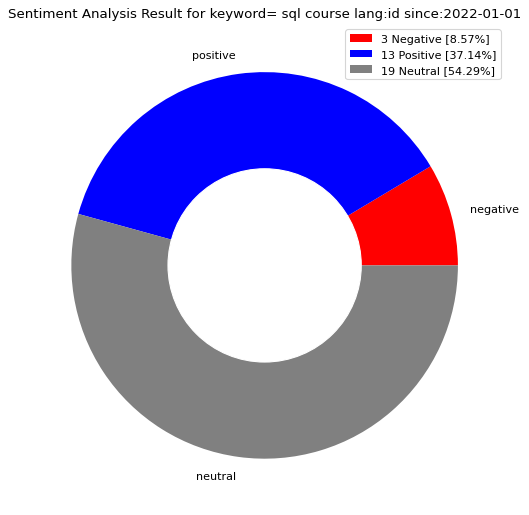

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Bootcamp SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "bootcamp sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_bootcampsql.csv')

In [ ]:
url='https://drive.google.com/file/d/196B6Iusi5ikVACaBd7W5_oPwXpLRfSR8/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "bootcamp sql lang:id since:2022-01-01"

bootcampSQL = pd.read_csv(file_name)
bootcampSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-17 08:27:39+00:00,saltykittenz,"@mufqam @pacarchanyeolll @worksfess gatauuuu, ..."
1,1,2022-04-16 10:56:25+00:00,FSyah1111,@fairywoodpprink Bantu jawab ya kak. Gw sender...
2,2,2022-04-16 05:40:50+00:00,Kak_Bagass,"@worksfess Hi nder, boleh tahu gak ikut bootca..."
3,3,2022-04-09 16:02:48+00:00,ougustaaz,@cahyadi_es Yang gamau kalah sama bocah 12 tah...
4,4,2022-04-06 09:37:07+00:00,hapidzf21,Bootcamp SQL Lengkap 2022: Beralih dari Nol ke...


In [ ]:
bootcampSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16 non-null     int64 
 1   Date        16 non-null     object
 2   User        16 non-null     object
 3   Tweet       16 non-null     object
dtypes: int64(1), object(3)
memory usage: 640.0+ bytes


In [ ]:
tw_list = bootcampSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-17 08:27:39+00:00,saltykittenz,"gatauuuu, coba cari2 bootcamp aja. basicnya...","@mufqam @pacarchanyeolll @worksfess gatauuuu, ..."
1,1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,@fairywoodpprink Bantu jawab ya kak. Gw sender...
2,2,2022-04-16 05:40:50+00:00,Kak_Bagass,"hi nder, boleh tahu gak ikut bootcamp di mana...","@worksfess Hi nder, boleh tahu gak ikut bootca..."
3,3,2022-04-09 16:02:48+00:00,ougustaaz,"yang gamau kalah sama bocah 12 tahun, nih men...",@cahyadi_es Yang gamau kalah sama bocah 12 tah...
4,4,2022-04-06 09:37:07+00:00,hapidzf21,bootcamp sql lengkap 2022: beralih dari nol ke...,Bootcamp SQL Lengkap 2022: Beralih dari Nol ke...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 08:27:39+00:00,saltykittenz,"gatauuuu, coba cari2 bootcamp aja. basicnya...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,0.333333,0.375,neutral,0.0,1.000,0.000,0.0000
2,2022-04-16 05:40:50+00:00,Kak_Bagass,"hi nder, boleh tahu gak ikut bootcamp di mana...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
3,2022-04-09 16:02:48+00:00,ougustaaz,"yang gamau kalah sama bocah 12 tahun, nih men...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
4,2022-04-06 09:37:07+00:00,hapidzf21,bootcamp sql lengkap 2022: beralih dari nol ke...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
5,2022-03-31 22:16:21+00:00,hapidzf21,microsoft sql server lengkap dari awal: bootca...,0.100000,0.100,neutral,0.0,1.000,0.000,0.0000
6,2022-03-23 12:49:17+00:00,avvestars,lagi ikut mini bootcamp data analytics terus t...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
7,2022-03-22 04:11:11+00:00,Sebutsaja__,"hmm, sepertinya sdh cukup utk lamar2 nder\n\n...",0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
8,2022-03-19 06:45:00+00:00,worksfess,work! halo temen temen disini ada yang tau cou...,0.400000,0.800,positive,0.0,0.883,0.117,0.5562
9,2022-03-01 12:15:58+00:00,mrigann,day 9/66\nkarena minggu depan mulai bootcamp b...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
8,2022-03-19 06:45:00+00:00,worksfess,work! halo temen temen disini ada yang tau cou...,0.4,0.8,positive,0.0,0.883,0.117,0.5562
11,2022-02-14 09:27:41+00:00,dikicuy,"🤠: pengalaman ngoding apa mas diki?\n😀: sql, p...",0.0,0.0,positive,0.0,0.806,0.194,0.7351
15,2022-01-19 03:37:29+00:00,prkdlx,"sebelum lanjut, aku mau kasi info dulu nih, ad...",0.0,0.0,positive,0.0,0.942,0.058,0.2960


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-17 08:27:39+00:00,saltykittenz,"gatauuuu, coba cari2 bootcamp aja. basicnya...",0.000000,0.000,neutral,0.0,1.0,0.0,0.0
1,2022-04-16 10:56:25+00:00,FSyah1111,bantu jawab ya kak. gw sender. biar ga dikira...,0.333333,0.375,neutral,0.0,1.0,0.0,0.0
2,2022-04-16 05:40:50+00:00,Kak_Bagass,"hi nder, boleh tahu gak ikut bootcamp di mana...",0.000000,0.000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,3,18.75
neutral,13,81.25


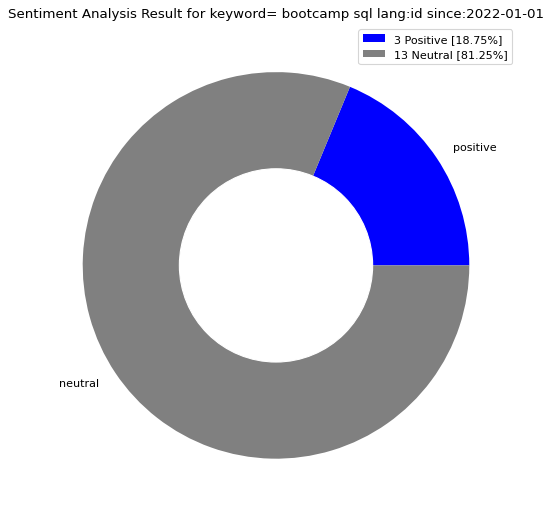

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
#negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
#neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [#str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Training SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "training sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_trainingsql.csv')

In [ ]:
url='https://drive.google.com/file/d/1bP_GGYAQ5x1ZJOAx67Yj3u0CxjEDt2BQ/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "training sql lang:id since:2022-01-01"

trainingSQL = pd.read_csv(file_name)
trainingSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-02 22:10:28+00:00,remote_dev_jobs,"Data Engineer at Betterup, Inc. #Advocate #BI ..."
1,1,2022-03-06 11:37:42+00:00,shananna_,Next week dah start external training for SQL....
2,2,2022-03-05 19:10:28+00:00,remote_dev_jobs,"Data Engineer at Betterup, Inc. #Advocate #BI ..."
3,3,2022-02-28 15:34:03+00:00,annisaafebrinaa,Yesss nambah ilmu baru.. ikut SQL training dar...
4,4,2022-01-28 08:59:15+00:00,ImranAB_,Aku baru settle supporting basic sql training ...


In [ ]:
trainingSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5 non-null      int64 
 1   Date        5 non-null      object
 2   User        5 non-null      object
 3   Tweet       5 non-null      object
dtypes: int64(1), object(3)
memory usage: 288.0+ bytes


In [ ]:
tw_list = trainingSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...","Data Engineer at Betterup, Inc. #Advocate #BI ..."
1,1,2022-03-06 11:37:42+00:00,shananna_,next week dah start external training for sql....,Next week dah start external training for SQL....
2,2,2022-03-05 19:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...","Data Engineer at Betterup, Inc. #Advocate #BI ..."
3,3,2022-02-28 15:34:03+00:00,annisaafebrinaa,yesss nambah ilmu baru.. ikut sql training dar...,Yesss nambah ilmu baru.. ikut SQL training dar...
4,4,2022-01-28 08:59:15+00:00,ImranAB_,aku baru settle supporting basic sql training ...,Aku baru settle supporting basic sql training ...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.000,0.0000,neutral,0.0,1.000,0.000,0.0000
1,2022-03-06 11:37:42+00:00,shananna_,next week dah start external training for sql....,0.000,0.0500,neutral,0.0,1.000,0.000,0.0000
2,2022-03-05 19:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.000,0.0000,neutral,0.0,1.000,0.000,0.0000
3,2022-02-28 15:34:03+00:00,annisaafebrinaa,yesss nambah ilmu baru.. ikut sql training dar...,0.000,0.0000,neutral,0.0,1.000,0.000,0.0000
4,2022-01-28 08:59:15+00:00,ImranAB_,aku baru settle supporting basic sql training ...,0.125,0.1875,positive,0.0,0.805,0.195,0.4404


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
4,2022-01-28 08:59:15+00:00,ImranAB_,aku baru settle supporting basic sql training ...,0.125,0.1875,positive,0.0,0.805,0.195,0.4404


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-02 22:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.0,0.00,neutral,0.0,1.0,0.0,0.0
1,2022-03-06 11:37:42+00:00,shananna_,next week dah start external training for sql....,0.0,0.05,neutral,0.0,1.0,0.0,0.0
2,2022-03-05 19:10:28+00:00,remote_dev_jobs,"data engineer at betterup, inc. #advocate #bi ...",0.0,0.00,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
positive,1,20.0
neutral,4,80.0


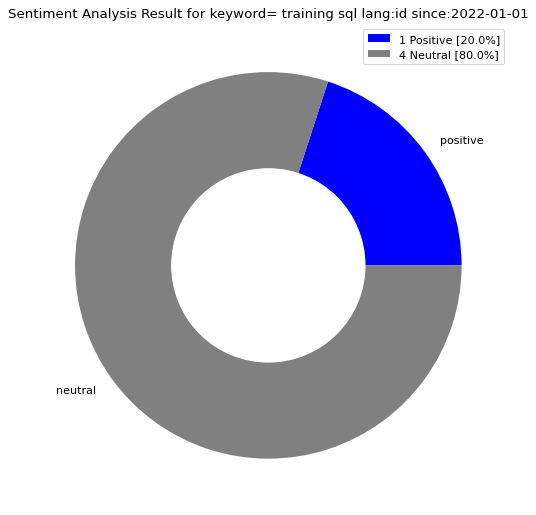

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
#negative = pc['Percentage']['negative']

pos = pc['Total']['positive']
neu = pc['Total']['neutral']
#neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [#str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Kelas SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "kelas sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_kelassql.csv')

In [ ]:
url='https://drive.google.com/file/d/1hcDZz27asktQhxjqiSGal98ArSIm3OJ0/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "kelas sql lang:id since:2022-01-01"

kelasSQL = pd.read_csv(file_name)
kelasSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 03:30:40+00:00,devil_Yrin,njiiir ini lahi kelas lain gue malah mskin dat...
1,1,2022-04-10 10:43:59+00:00,ululazmisyfr,Empat hari kedepan selama nunggu buka puasa ak...
2,2,2022-04-02 02:20:00+00:00,aqshalrzq_,@codingfess dulu pas waktu smk ngeliat ada kel...
3,3,2022-03-31 07:23:14+00:00,crazsouly,1. kelas offline\n2. sql kontol gak ngerti\n3....
4,4,2022-03-27 13:43:50+00:00,benimaru____,@lifeatpacmann @pacmannai nyambi kelas python ...


In [ ]:
kelasSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12 non-null     int64 
 1   Date        12 non-null     object
 2   User        12 non-null     object
 3   Tweet       12 non-null     object
dtypes: int64(1), object(3)
memory usage: 512.0+ bytes


In [ ]:
tw_list = kelasSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 03:30:40+00:00,devil_Yrin,njiiir ini lahi kelas lain gue malah mskin dat...,njiiir ini lahi kelas lain gue malah mskin dat...
1,1,2022-04-10 10:43:59+00:00,ululazmisyfr,empat hari kedepan selama nunggu buka puasa ak...,Empat hari kedepan selama nunggu buka puasa ak...
2,2,2022-04-02 02:20:00+00:00,aqshalrzq_,dulu pas waktu smk ngeliat ada kelas sebelah ...,@codingfess dulu pas waktu smk ngeliat ada kel...
3,3,2022-03-31 07:23:14+00:00,crazsouly,1. kelas offline\n2. sql kontol gak ngerti\n3....,1. kelas offline\n2. sql kontol gak ngerti\n3....
4,4,2022-03-27 13:43:50+00:00,benimaru____,nyambi kelas python dan sql ya pacmin? haha,@lifeatpacmann @pacmannai nyambi kelas python ...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 03:30:40+00:00,devil_Yrin,njiiir ini lahi kelas lain gue malah mskin dat...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
1,2022-04-10 10:43:59+00:00,ululazmisyfr,empat hari kedepan selama nunggu buka puasa ak...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
2,2022-04-02 02:20:00+00:00,aqshalrzq_,dulu pas waktu smk ngeliat ada kelas sebelah ...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
3,2022-03-31 07:23:14+00:00,crazsouly,1. kelas offline\n2. sql kontol gak ngerti\n3....,0.0,0.0,negative,0.028,0.972,0.0,-0.1280
4,2022-03-27 13:43:50+00:00,benimaru____,nyambi kelas python dan sql ya pacmin? haha,0.2,0.3,positive,0.000,0.700,0.3,0.4588
5,2022-02-22 16:00:16+00:00,Ir_syahbanu,gua nunggu laras buka kelas python sama sql ...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
6,2022-02-21 09:14:04+00:00,nomadiclovers,somehow gue ngerasa bego banget berasa gak jag...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
7,2022-02-03 14:12:18+00:00,Matahari9841,ikutan kelas gratisan tentang data analis aja ...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
8,2022-01-29 11:21:12+00:00,sarangeulhetdah,anjir mainan sql gue jaman kelas 3 apa 2 ye sa...,0.0,0.0,neutral,0.000,1.000,0.0,0.0000
9,2022-01-29 05:06:00+00:00,NrAfiqaah_,"time kelas elok je msteams ni, time nak submit...",0.0,0.0,neutral,0.000,1.000,0.0,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
4,2022-03-27 13:43:50+00:00,benimaru____,nyambi kelas python dan sql ya pacmin? haha,0.2,0.3,positive,0.0,0.7,0.3,0.4588


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
3,2022-03-31 07:23:14+00:00,crazsouly,1. kelas offline\n2. sql kontol gak ngerti\n3....,0.0,0.0,negative,0.028,0.972,0.0,-0.128


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 03:30:40+00:00,devil_Yrin,njiiir ini lahi kelas lain gue malah mskin dat...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-10 10:43:59+00:00,ululazmisyfr,empat hari kedepan selama nunggu buka puasa ak...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
2,2022-04-02 02:20:00+00:00,aqshalrzq_,dulu pas waktu smk ngeliat ada kelas sebelah ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,8.33
positive,1,8.33
neutral,10,83.33


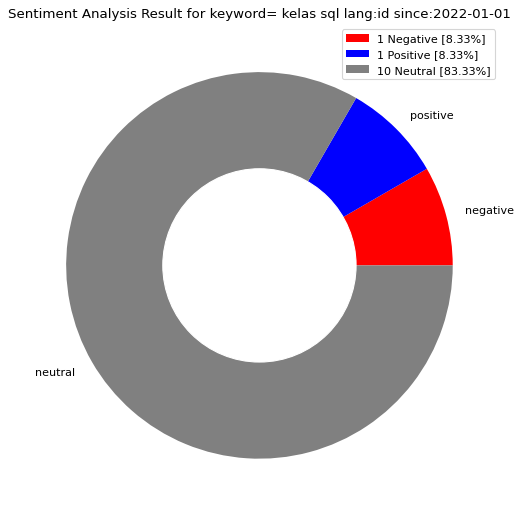

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Les SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "les sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_lessql.csv')

In [ ]:
url='https://drive.google.com/file/d/11f7qrXAoaXb9rpZFZxo2Pd4Bn6PPitao/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "les sql lang:id since:2022-01-01"

lesSQL = pd.read_csv(file_name)
lesSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-11 15:03:44+00:00,Saefullloh,"Meanwhile lagi les bahasa Jepang, pengen ngamb..."
1,1,2022-04-09 20:42:20+00:00,RemidiKamal,@walidnb17 Makaynsh mouchkil wakha ykon endk m...


In [ ]:
lesSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2 non-null      int64 
 1   Date        2 non-null      object
 2   User        2 non-null      object
 3   Tweet       2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes


In [ ]:
tw_list = lesSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...","Meanwhile lagi les bahasa Jepang, pengen ngamb..."
1,1,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,@walidnb17 Makaynsh mouchkil wakha ykon endk m...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...",-0.75,1.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,0.00,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-11 15:03:44+00:00,Saefullloh,"meanwhile lagi les bahasa jepang, pengen ngamb...",-0.75,1.0,neutral,0.0,1.0,0.0,0.0
1,2022-04-09 20:42:20+00:00,RemidiKamal,makaynsh mouchkil wakha ykon endk master f ma...,0.00,0.0,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
neutral,2,100.0


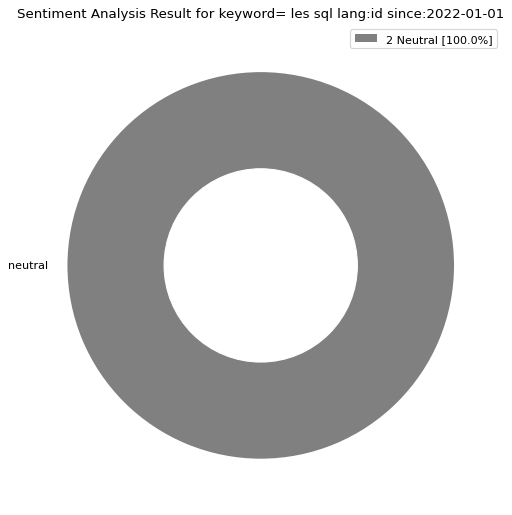

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart

neutral = pc['Percentage']['neutral']
#negative = pc['Percentage']['negative']

neu = pc['Total']['neutral']
#neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [#str(neg)+' Negative ['+str(negative)+'%]',
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Pelatihan SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "pelatihan sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_pelatihansql.csv')

In [ ]:
url='https://drive.google.com/file/d/1Xp9nZD9kOxCKQP8HYyC6Uc_kKn0f6xoN/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "pelatihan sql lang:id since:2022-01-01"

pelatihanSQL = pd.read_csv(file_name)
pelatihanSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-01-19 09:46:38+00:00,seblakcyekerr,tugas pelatihan gue bisa kelar sblm closing bs...


In [ ]:
pelatihanSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1 non-null      int64 
 1   Date        1 non-null      object
 2   User        1 non-null      object
 3   Tweet       1 non-null      object
dtypes: int64(1), object(3)
memory usage: 160.0+ bytes


In [ ]:
tw_list = pelatihanSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-01-19 09:46:38+00:00,seblakcyekerr,tugas pelatihan gue bisa kelar sblm closing bs...,tugas pelatihan gue bisa kelar sblm closing bs...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-01-19 09:46:38+00:00,seblakcyekerr,tugas pelatihan gue bisa kelar sblm closing bs...,0.0,0.0,negative,0.116,0.884,0.0,-0.3612


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-01-19 09:46:38+00:00,seblakcyekerr,tugas pelatihan gue bisa kelar sblm closing bs...,0.0,0.0,negative,0.116,0.884,0.0,-0.3612


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,1,100.0


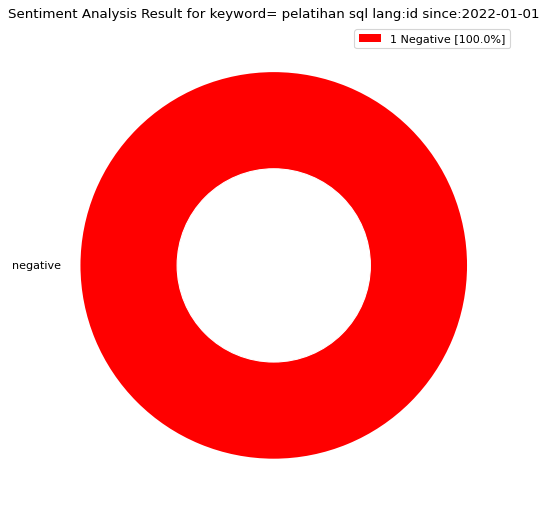

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
#positive = pc['Percentage']['positive']
#neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
#pos = pc['Total']['positive']
#neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]']
          #str(pos)+' Positive ['+str(positive)+'%]' ,
          #str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()

# **Belajar SQL**

In [ ]:
# Jangan di run lagi, soalnya lumayan lama. dataset hasil scraping dah ku save bentuk csv. nanti tinggal pake csv itu buat sentiment analysis

query = "belajar sql lang:id until:2022-04-20 since:2022-01-01"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])

df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
df.head()

# to save to csv
df.to_csv('tweets_belajarsql.csv')

In [ ]:
url='https://drive.google.com/file/d/1IcOSwqEMHaK8RCyjFxxBbOh3ZwCJ1xa5/view?usp=sharing'
file_id=url.split('/')[-2]
file_name='https://drive.google.com/uc?id=' + file_id
query = "belajar sql lang:id since:2022-01-01"

belajarSQL = pd.read_csv(file_name)
belajarSQL.head()

,Unnamed: 0,Date,User,Tweet
0,0,2022-04-19 06:25:32+00:00,sincosdxdy,@asmurcom @worksfess wah udh two days ago. apa...
1,1,2022-04-18 16:36:09+00:00,anggun1626,"Day 2\n\nHari ini aku belajar tentang SQL, mel..."
2,2,2022-04-17 08:44:59+00:00,tsunder12835345,"@FSyah1111 Kak sorry tanya di sini, selama bel..."
3,3,2022-04-17 07:37:31+00:00,teecupoftea,"Seru nih belajar sql, bakalan jarang ngolah di..."
4,4,2022-04-17 02:40:47+00:00,IqbalulMustaqim,@worksfess @yntaaaa_ Semoga belajar sql ku lan...


In [ ]:
belajarSQL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  234 non-null    int64 
 1   Date        234 non-null    object
 2   User        234 non-null    object
 3   Tweet       234 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.4+ KB


In [ ]:
tw_list = belajarSQL

#Cleaning Text (RT, Punctuation etc)

tw_list['text'] = tw_list['Tweet']
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",str(x))
remove_tag = lambda x: re.sub(r'@\S+ '," ",x)
remove_link = lambda x: re.sub(r'http\S+', '', x)

tw_list['Tweet'] = tw_list.Tweet.map(remove_rt).map(remove_tag).map(remove_link)
tw_list['Tweet'] = tw_list.Tweet.str.lower()
tw_list.head()

,Unnamed: 0,Date,User,Tweet,text
0,0,2022-04-19 06:25:32+00:00,sincosdxdy,wah udh two days ago. apakah masih open bang...,@asmurcom @worksfess wah udh two days ago. apa...
1,1,2022-04-18 16:36:09+00:00,anggun1626,"day 2\n\nhari ini aku belajar tentang sql, mel...","Day 2\n\nHari ini aku belajar tentang SQL, mel..."
2,2,2022-04-17 08:44:59+00:00,tsunder12835345,"kak sorry tanya di sini, selama belajar mandi...","@FSyah1111 Kak sorry tanya di sini, selama bel..."
3,3,2022-04-17 07:37:31+00:00,teecupoftea,"seru nih belajar sql, bakalan jarang ngolah di...","Seru nih belajar sql, bakalan jarang ngolah di..."
4,4,2022-04-17 02:40:47+00:00,IqbalulMustaqim,semoga belajar sql ku lancar😭,@worksfess @yntaaaa_ Semoga belajar sql ku lan...


In [ ]:
# Removing [Unnamed:0] and [text]
tw_list.drop(['Unnamed: 0', 'text'], axis=1, inplace=True)

# Removing Null Row
tw_list.dropna(inplace=True)
tw_list.reset_index(drop=True, inplace=True)

# Removing Duplicate row
tw_list.drop_duplicates(inplace = True)

In [ ]:
# Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

noOfTweet = len(tw_list)
positive = 0
negative = 0
neutral = 0
polarity = 0
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['Tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list.iterrows():
  analysis = TextBlob(str(row['Tweet']))
  score = SentimentIntensityAnalyzer().polarity_scores(str(row['Tweet']))
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
    negative += 1
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
    positive += 1
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
    neutral += 1

  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
tw_list.head(10)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 06:25:32+00:00,sincosdxdy,wah udh two days ago. apakah masih open bang...,0.000,0.3125,neutral,0.000,1.000,0.000,0.0000
1,2022-04-18 16:36:09+00:00,anggun1626,"day 2\n\nhari ini aku belajar tentang sql, mel...",-0.125,0.3750,positive,0.000,0.871,0.129,0.5719
2,2022-04-17 08:44:59+00:00,tsunder12835345,"kak sorry tanya di sini, selama belajar mandi...",-0.500,1.0000,negative,0.064,0.936,0.000,-0.0772
3,2022-04-17 07:37:31+00:00,teecupoftea,"seru nih belajar sql, bakalan jarang ngolah di...",0.000,0.0000,positive,0.000,0.786,0.214,0.4588
4,2022-04-17 02:40:47+00:00,IqbalulMustaqim,semoga belajar sql ku lancar😭,0.000,0.0000,neutral,0.000,1.000,0.000,0.0000
5,2022-04-17 01:11:30+00:00,evilwonkyu98,"sebenernya bisa maksimalin di excel sih, terg...",0.400,0.6000,positive,0.000,0.868,0.132,0.6124
6,2022-04-16 21:20:03+00:00,whassappguys,"gue bisa python, sql masih belajar bang",0.000,0.0000,neutral,0.000,1.000,0.000,0.0000
7,2022-04-16 19:06:52+00:00,m_octaviaaa,"pengen banting setir, tapi belajar sql aja ga ...",0.000,0.0000,neutral,0.000,1.000,0.000,0.0000
8,2022-04-16 18:00:00+00:00,hepivia,wkakaka tp gue jg seneng sih kalo gebetan gw ...,0.000,0.0000,neutral,0.000,1.000,0.000,0.0000
9,2022-04-16 17:00:38+00:00,h0pelessr0man16,this drama lumayan menyita perhatian gue terle...,0.100,0.3500,neutral,0.000,1.000,0.000,0.0000


In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [ ]:
tw_list_positive.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,2022-04-18 16:36:09+00:00,anggun1626,"day 2\n\nhari ini aku belajar tentang sql, mel...",-0.125,0.375,positive,0.0,0.871,0.129,0.5719
3,2022-04-17 07:37:31+00:00,teecupoftea,"seru nih belajar sql, bakalan jarang ngolah di...",0.000,0.000,positive,0.0,0.786,0.214,0.4588
5,2022-04-17 01:11:30+00:00,evilwonkyu98,"sebenernya bisa maksimalin di excel sih, terg...",0.400,0.600,positive,0.0,0.868,0.132,0.6124


In [ ]:
tw_list_negative.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
2,2022-04-17 08:44:59+00:00,tsunder12835345,"kak sorry tanya di sini, selama belajar mandi...",-0.50,1.0,negative,0.064,0.936,0.0,-0.0772
28,2022-04-16 04:29:01+00:00,i3i___i3i,akuuuu udah belajar dasar sql penasaran sm co...,-0.75,1.0,negative,0.182,0.818,0.0,-0.4404
43,2022-04-10 16:34:50+00:00,s_skhalishah,sebagai alumni mahasiswa non-it target sampe a...,0.00,0.0,negative,0.082,0.918,0.0,-0.3612


In [ ]:
tw_list_neutral.head(3)

,Date,User,Tweet,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2022-04-19 06:25:32+00:00,sincosdxdy,wah udh two days ago. apakah masih open bang...,0.0,0.3125,neutral,0.0,1.0,0.0,0.0
4,2022-04-17 02:40:47+00:00,IqbalulMustaqim,semoga belajar sql ku lancar😭,0.0,0.0000,neutral,0.0,1.0,0.0,0.0
6,2022-04-16 21:20:03+00:00,whassappguys,"gue bisa python, sql masih belajar bang",0.0,0.0000,neutral,0.0,1.0,0.0,0.0


In [ ]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False, ascending=True)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,'sentiment')

,Total,Percentage
negative,7,2.99
positive,58,24.79
neutral,169,72.22


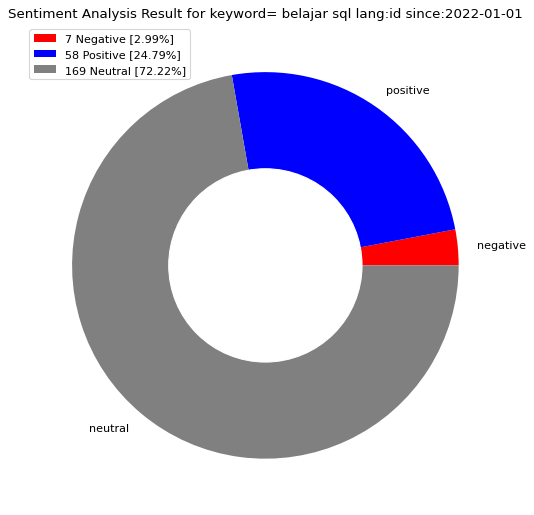

In [ ]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,'sentiment')
pc = pichart
positive = pc['Percentage']['positive']
neutral = pc['Percentage']['neutral']
negative = pc['Percentage']['negative']
pos = pc['Total']['positive']
neu = pc['Total']['neutral']
neg = pc['Total']['negative']
names = pc.index
size = pc['Percentage']

# Create a circle for the center of the plot
labels = [str(neg)+' Negative ['+str(negative)+'%]',
          str(pos)+' Positive ['+str(positive)+'%]' ,
          str(neu)+' Neutral ['+str(neutral)+'%]']

from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(size, labels=names, colors=['red','blue','gray'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sentiment Analysis Result for keyword= '+query+'' )
plt.legend(labels)
plt.show()